In [1]:
# import necessary modules

import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import os
import sys
import glob
import pickle
import warnings
import tqdm
import pandas as pd
import librosa
import librosa.display as display
import biosppy
import scipy.signal as sig
from scipy.stats import zscore
from scipy.io import wavfile
from scipy.fft import fft,fftfreq
from scipy.fftpack import fft

warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib as mlp
mlp.rc("xtick",labelsize=10)
mlp.rc("ytick",labelsize=10)
mlp.rc("axes",labelsize=11)
plt.rcParams["figure.figsize"] = [11,5]
plt.rcParams["figure.dpi"] = 300

import tensorflow as tf
import sklearn
from tensorflow import keras
from keras.layers import TimeDistributed
from keras.layers import LSTM
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

CURR_DIR = os.getcwd()

/home/rimesh/Files/softwareFiles/python/ml/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
Using TensorFlow backend.


In [2]:
MAIN_DIR = "."
if os.path.basename(os.getcwd())!="Silent-Interface-for-IOT-Devices":
    os.chdir("..")

DATA_DIR = os.path.join(MAIN_DIR,"new dataset")
FIG_DIR = os.path.join(MAIN_DIR,"figures")
PICKLE_DIR = os.path.join(MAIN_DIR,"pickles")
os.makedirs(FIG_DIR,exist_ok=True)
os.makedirs(PICKLE_DIR,exist_ok=True)

# hardware definitions
"""
https://docs.openbci.com/docs/02Cyton/CytonDataFormat#:~:text=By%20default%2C%20our%20Arduino%20sketch,of%200.02235%20microVolts%20per%20count
"""
SAMPLING_RATE = 250 #Hz
NUM_CHANNELS = 8 
ADC_RESOLUTION = 24 #bits
ADC_GAIN = 24.0
REF_VOLTAGE = 4.5 #Volts
SCALE_FACTOR = (REF_VOLTAGE/float((pow(2,23))-1)/ADC_GAIN)*1000000.0 #micro-volts

# dataset definitions
SPEAKER = ["RL","RN","SR","US"]
SESSION = ["session"+str(i) for i in range(1,9)]
MODE = ["mentally","mouthed"]
SENTENCES =["अबको समय सुनाउ","एउटा सङ्गित बजाउ","आजको मौसम बताउ","बत्तिको अवस्था बदल","पङ्खाको स्तिथी बदल"]
LABELS = np.array(SENTENCES)[[3, 2, 1, 4, 0, 3, 2, 1, 4, 0, 3, 2, 1, 4, 0]]
WORDS = ["समय","सङ्गित","मौसम","बत्ति","पङ्खा"]


## pickle get set function

In [26]:
def getPickleFile(pickelFileName):
    if pickelFileName in os.listdir(PICKLE_DIR):
        print("[*] Fetching raw data from pickle file : ",pickelFileName)
        importedData = pickle.load(open(os.path.join(PICKLE_DIR, pickelFileName),"rb"))
        print("[+] Done!")
        return importedData
    else: 
        print("[-] Failed to get file :", pickelFileName)
        return False

def storePickleFile(dataToStore, pickelFileName):
    pickle.dump(dataToStore,open(os.path.join(PICKLE_DIR, pickelFileName),"wb"))
    print('[+] data saved to file : ',pickelFileName)

# Parser - raw

In [4]:
def parser(files, NORMALIZE=True, DEPLOY=False, utteranceCountPerFile = 15):
    
    """
    parser function to extract utterances from .txt file and store them in a dictionary
    """
    
    # PERCENTILES FOR LENGTH NORMALIZATION
    if(NORMALIZE==True):
        percentile_95 = 1602
        percentile_97 = 1614
        percentile_99 = 1648
        percentile_100 = 1875
    else:
        percentile_95 = percentile_97 = percentile_99 = percentile_100 = -1
        
    dataset = {"data":[], "speaker":[],"session":[],"labels":[]}
    
    def get_data(file):
        signal = read_data(file)
        
        if(DEPLOY==True):
            dataset["data"].extend(signal)
            return
        
        if(len(signal) != utteranceCountPerFile):
            return

        session = file.split("/")[-2]
        speaker = file.split("/")[-3]
        
        dataset["data"].extend(signal)
        dataset["speaker"].extend([speaker]*len(signal))
        dataset["session"].extend([session]*len(signal))
        dataset["labels"].extend(LABELS)
        
    def read_data(file):
        f = open(file, 'r')
        contents = map(lambda x : x.strip(), f.readlines())
        #the file starts with '%' and some instruction before data and removing these data 
        frames_original = list(filter(lambda x : x and x[0] != '%', contents))[1:]
        #the data row contains channels info digital trigger and accelerometer info separated by comma
        frames_original = list(map(lambda s : list(map( lambda ss: ss.strip(), s.split(','))), frames_original))
        # (8 channels) + digital triggers
        # the digital trigger is in a[16], used to indicate the utterance
        frames = list(map(lambda a: list(map(float, a[1:9])) + [float(a[16])] , frames_original))
        frames = np.array(frames)
        indices = []
        signal = []
        for index,f in enumerate(frames[:,-1]):
            if(bool(f) ^ bool(frames[(index+1) if ((index+1)<len(frames)) else index,-1]) ):
                indices.append(index)
                if len(indices)>1 and len(indices)%2==0:
                    frame_len = indices[len(indices)-1] - indices[len(indices)-2]
                    if(frame_len<percentile_99):
                        pad = int(np.ceil((percentile_99 - frame_len)/2))
                    else:
                        pad = 0
                    left_pad = indices[len(indices)-2] - pad
                    right_pad = indices[len(indices)-1] + pad
                    a_frame = (frames[left_pad:right_pad,:-1])[:percentile_99]
                    signal.append(a_frame)
    
        # convert to microVolts and return
        return np.array(signal)*SCALE_FACTOR
        
    for file,i in zip(files,tqdm.tqdm(range(1,len(files)+1),desc="PARSING DATA")):
        get_data(file)
    
    return dataset

In [53]:
def getAugmentedData(all_data, shift_length=100):
    
    DATA_LENGTH = len(all_data["labels"])
    
    def time_shift(data,SHIFT_LEN = shift_length, SHIFT_DIR ="RIGHT", index=0):
        if SHIFT_DIR != "RIGHT":
            SHIFT_LEN = - SHIFT_LEN
            index = -1
        shifted_data = np.roll(data,SHIFT_LEN)
        if SHIFT_LEN>0:
            shifted_data[:SHIFT_LEN] = data[index]
        else:
            shifted_data[SHIFT_LEN:] = data[index]
        return shifted_data
    
    for i in range(DATA_LENGTH):
        aug_data = []
        for j in range(8):
            temp_data1 = time_shift(all_data["data"][i][:,j],SHIFT_DIR="LEFT")
            aug_data.append(temp_data1)

        all_data["data"].extend([(np.array(aug_data)).T])
        all_data["labels"].extend([all_data["labels"][i]])
        all_data["speaker"].extend([all_data["speaker"][i]])
        all_data["session"].extend([all_data["session"][i]])

    for i in range(DATA_LENGTH):
        aug_data = []
        for j in range(8):
            temp_data2 = time_shift(all_data["data"][i][:,j],SHIFT_DIR="RIGHT")
            aug_data.append(temp_data2)

        all_data["data"].extend([(np.array(aug_data)).T])
        all_data["labels"].extend([all_data["labels"][i]])
        all_data["speaker"].extend([all_data["speaker"][i]])
        all_data["session"].extend([all_data["session"][i]])

    return all_data

# filtering

In [7]:
def signal_pipeline(data,RICKER=False):

    """
    CORRECT DC DRIFT --> CORRECT DC BIAS --> SMOOTHING SIGNAL --> NORMALIZE DATA --> FILTER DATA 	
    """
    filter_data = []

    def digital_filter(data,HPF=0.5,LPF=10,H_ORDER=4,L_ORDER=4,SR=250):
        """
        HPF --> NOTCH --> LPF --> RICKER CONVOLUTION
        """

        # highpass filter
        f_signal = biosppy.signals.tools.filter_signal(data,ftype="butter",band="highpass",order=H_ORDER,sampling_rate=SR,frequency=HPF)
        # notch filter
        b,a = sig.iirnotch(50,30,SR)
        f_signal = sig.lfilter(b,a,f_signal[0])

        # lowpass filter
        f_signal = biosppy.signals.tools.filter_signal(f_signal,ftype="butter",band="lowpass",order=L_ORDER,sampling_rate=SR,frequency=LPF)

        if(RICKER==True):
            # RICKER CONVOLUTION TO REMOVE HEARTBEAT ARTIFACTS
            ricker_width = 35 * SR // 250
            ricker_sigma = 4.0 * SR #/https://www.kaggle.com/davids1992/speech-representation-and-data-exploration#1.-Visualization 250
            ricker = sig.ricker(ricker_width,ricker_sigma)
            # normalize ricker
            ricker = np.array(ricker, np.float32) / np.sum(np.abs(ricker))
            convolution = sig.convolve(f_signal[0],ricker,mode="same")
            return (f_signal[0]-2*convolution)

        return f_signal[0]

    def process_signal(data):
        f_data = []
        for i in range(8):
            # correction of DC drift
            c_data = data[:,i]- data[0,i]

            # correct DC bias
            c_data = c_data - np.mean(c_data)

            # normalize and filter data
            c_data = digital_filter(c_data)
            f_data.append(c_data)

        return np.array(f_data).T

    for d,i in zip(data,tqdm.tqdm(range(1,len(data)+1),desc="PROCESSING DATA: ")):
        temp_data = process_signal(d)
        filter_data.extend([temp_data])

    return np.array(filter_data)

## Features function

In [50]:
import scipy.signal as sig
def getSpectrogram(sdata):
    M = 60
    win = sig.windows.hann(M, sym=False)
    return sig.spectrogram(x=np.array(sdata), fs=SAMPLING_RATE, window=win,
                       nperseg=M, noverlap=3*M/4, nfft=M)

def feature_pipeline_Spectrogram(data):
    feature_data = []
    def process_signal(data):
        f_data = []
        for i in range(8):
            _, _, c_data = getSpectrogram(data[:, i])
            f_data.append(c_data)
        return np.array(f_data)
    
    for d,i in zip(data, tqdm.tqdm(range(1,len(data)+1),desc="EXTRACTING DATA: ")):
        temp_data = process_signal(d)
        feature_data.extend([temp_data])
    return np.array(feature_data)

def plotSpectrogram(singleChannelData):
    freq, time, spec = getSpectrogram(singleChannelData)
    plt.pcolormesh(time, freq, spec, shading='gouraud')
    plt.title('spectrogram')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    return freq, time, spec

In [9]:
def getMelspectrogram(mdata):
    S = librosa.feature.melspectrogram(np.asfortranarray(mdata), sr=SAMPLING_RATE,
                            n_mels=2,
                            n_fft = int(32*10**-3*SAMPLING_RATE),
                            hop_length=int(10*10**-3*SAMPLING_RATE)
                            )

    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    log_S = librosa.power_to_db(S, ref=np.max)
    return log_S

def feature_pipeline_melspectrogram(data):
    feature_data = []
    def process_signal(data):
        f_data = []
        for i in range(8):
            c_data = getMelspectrogram(data[:, i])
            f_data.append(c_data)
        return np.array(f_data)
    
    for d,i in zip(data,tqdm.tqdm(range(1,len(data)+1),desc="EXTRACTING DATA: ")):
        temp_data = process_signal(d)
        feature_data.extend([temp_data])
    return np.array(feature_data)

def plotMelspectrogram(singleChannelData):
    log_S = getMelspectrogram(singleChannelData)
    librosa.display.specshow(log_S, sr=SAMPLING_RATE, x_axis='time', y_axis='mel', fmax = 250/2)
    plt.title('Mel power spectrogram ')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()
    return log_S

In [10]:
def feature_pipeline_mfcc(data):
    feature_data = []
    def getMFCC(mdata):
        return librosa.feature.mfcc(y=np.asfortranarray(mdata),
                                    sr=SAMPLING_RATE,
                                    n_mfcc=13,
                                    n_mels = 30,
                                    n_fft=int(16*(10**-3)*SAMPLING_RATE),
                                    hop_length=int(10*(10**-3)*SAMPLING_RATE)
                                   )

    def process_signal(data):
        f_data = []
        for i in range(8):
            c_data = getMFCC(data[:, i])
            f_data.append(c_data)
    return np.array(f_data)
    
    for d,i in zip(data,tqdm.tqdm(range(1,len(data)+1),desc="EXTRACTING DATA: ")):
        temp_data = process_signal(d)
        feature_data.extend([temp_data])
    return np.array(feature_data)

### other function

In [40]:
def reshapeChannelIndexToLast(data_feature):
    reshape_feature = np.zeros((data_feature['data'].shape[0], data_feature['data'].shape[2],
                         data_feature['data'].shape[3], data_feature['data'].shape[1]))
    for i in range(data_feature['data'].shape[0]):
        for j in range(8):
            reshape_feature[i,:,:,j] = data_feature['data'][i,j,:,:]
    data_feature['data'] = reshape_feature
    return data_feature

## IMPORT DATASET

In [11]:
all_files = glob.glob(DATA_DIR+"/**/session?/*.txt",recursive=True)
print("The files in the dataset: ",len(all_files))

The files in the dataset:  165


In [12]:
testfiles = glob.glob(DATA_DIR+'/**/test/B.txt', recursive=True)
print(testfiles)

['./new dataset/RL/test/B.txt']


### parse raw data and filter

In [28]:
rawdata = parser(all_files, NORMALIZE=True)

PARSING DATA:  99%|█████████▉| 164/165 [07:32<00:02,  2.76s/it]


In [29]:
all_data_filtered = rawdata.copy()
all_data_filtered['data'] = signal_pipeline(rawdata['data'])
del rawdata
storePickleFile(all_data_filtered, 'data_dict_filtered.pickle')
del all_data_filtered

PROCESSING DATA: 100%|█████████▉| 2309/2310 [02:48<00:00, 13.71it/s]


[+] data saved to file :  data_dict_filtered.pickle


In [32]:
print(len(all_data_filtered['data']))
all_data_filtered['data'][0] == all_data_filtered['data'][1]

2310


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

### melspectrogram feature extraction

In [41]:
all_data_filtered = getPickleFile('data_dict_filtered.pickle')
all_data_feature = all_data_filtered.copy()
all_data_feature["data"] = feature_pipeline_melspectrogram(all_data_filtered["data"])

[*] Fetching raw data from pickle file :  data_dict_filtered.pickle


EXTRACTING DATA:   0%|          | 2/2310 [00:00<02:04, 18.49it/s]

[+] Done!


EXTRACTING DATA: 100%|█████████▉| 2309/2310 [01:51<00:00, 20.65it/s]


In [42]:
all_data_feature['data'].shape

(2310, 8, 2, 825)

In [43]:
all_data_feature = reshapeChannelIndexToLast(all_data_feature)
all_data_feature['data'].shape

In [45]:
del all_data_filtered
storePickleFile(all_data_feature, 'data_dict_melspectrogram.pickle')
del all_data_feature

[+] data saved to file :  data_dict_melspectrogram.pickle


### spectrogram feature extraction

In [51]:
all_data_filtered = getPickleFile('data_dict_filtered.pickle')
all_data_feature = all_data_filtered.copy()
all_data_feature["data"] = feature_pipeline_Spectrogram(all_data_filtered["data"])

[*] Fetching raw data from pickle file :  data_dict_filtered.pickle


EXTRACTING DATA:   0%|          | 2/2310 [00:00<02:22, 16.21it/s]

[+] Done!


EXTRACTING DATA:  25%|██▍       | 577/2310 [00:22<01:06, 25.91it/s]


KeyboardInterrupt: 

In [ ]:
all_data_feature['data'].shape

In [ ]:
all_data_feature = reshapeChannelIndexToLast(all_data_feature)
all_data_feature['data'].shape

In [ ]:
del all_data_filtered
storePickleFile(all_data_feature, 'data_dict_spectrogram.pickle')
del all_data_feature

### parse augmented data from filter  

In [ ]:
rawdata = parser(all_files, NORMALIZE=True)

In [ ]:
# all_data_filtered = rawdata.copy()
all_augmented_data = getAugmentedData(rawdata)
del rawdata
all_data_filtered['data'] = signal_pipeline(rawdata['data'])
del rawdata
storePickleFile(all_data_filtered, 'data_dict_filtered.pickle')
del all_data_filtered

In [54]:
all_data_filtered = getPickleFile('data_dict_filtered.pickle')
all_augmented_data = getAugmentedData(all_data_filtered)

[*] Fetching raw data from pickle file :  data_dict_filtered.pickle
[+] Done!


AttributeError: 'numpy.ndarray' object has no attribute 'extend'

In [ ]:
del all_data_filtered
storePickleFile(all_augmented_data, 'aug_data_dict.pickle')
del all_data_feature

## Parser raw

In [27]:
def parser(files,NORMALIZE=True,DEPLOY=False):
    
    """
    parser function to extract utterances from .txt file and store them in a dictionary
    """
    
    # PERCENTILES FOR LENGTH NORMALIZATION
    if(NORMALIZE==True):
        percentile_95 = 1602
        percentile_97 = 1614
        percentile_99 = 1648
        percentile_100 = 1875
    else:
        percentile_95 = percentile_97 = percentile_99 = percentile_100 = -1
        
    dataset = {"data":[], "speaker":[],"session":[],"labels":[]}
    
    def get_data(file):
        
        signal = read_data(file)
        
        if(DEPLOY==True):
            dataset["data"].extend(signal)
            return
        
        if(len(signal)!=10):
            return
        
        session = file.split("/")[-2]
        speaker = file.split("/")[-3]
        
        dataset["data"].extend(signal)
        dataset["speaker"].extend([speaker]*len(signal))
        dataset["session"].extend([session]*len(signal))
        dataset["labels"].extend(LABELS)
        
    
    def read_data(file):
        f = open(file, 'r')
        contents = map(lambda x : x.strip(), f.readlines())
        #the file starts with '%' and some instruction before data and removing these data 
        frames_original = list(filter(lambda x : x and x[0] != '%', contents))[1:]
        #the data row contains channels info digital trigger and accelerometer info separated by comma
        frames_original = list(map(lambda s : list(map( lambda ss: ss.strip(), s.split(','))), frames_original))
        # (8 channels) + digital triggers
        # the digital trigger is in a[16], used to indicate the utterance
        frames = list(map(lambda a: list(map(float, a[1:9])) + [float(a[16])] , frames_original))
        frames = np.array(frames)
        indices = []
        signal = []
        for index,f in enumerate(frames[:,-1]):
            if(bool(f) ^ bool(frames[(index+1) if ((index+1)<len(frames)) else index,-1]) ):
                indices.append(index)
                if len(indices)>1 and len(indices)%2==0:
                    frame_len = indices[len(indices)-1] - indices[len(indices)-2]
                    if(frame_len<percentile_99):
                        pad = int(np.ceil((percentile_99 - frame_len)/2))
                    else:
                        pad = 0
                    left_pad = indices[len(indices)-2] - pad
                    right_pad = indices[len(indices)-1] + pad
                    a_frame = (frames[left_pad:right_pad,:-1])[:percentile_99]
                    signal.append(a_frame)
    
        # convert to microVolts and return
        return np.array(signal)*SCALE_FACTOR
        
    for file,i in zip(files,tqdm.tqdm(range(1,len(files)+1),desc="PARSING DATA")):
        get_data(file)
    
    return dataset

In [28]:
fileName = "test_dict_B.pickle"
if fileName in os.listdir(PICKLE_DIR):
    print("Fetching raw data from pickle file ...")
    all_data = pickle.load(open(os.path.join(PICKLE_DIR, fileName),"rb"))
    print("Done!")
else:
    all_data = parser(all_files)
#     all_data = parser(testfiles)
    pickle.dump(all_data,open(os.path.join(PICKLE_DIR, fileName),"wb"))

PARSING DATA:   0%|          | 0/1 [00:04<?, ?it/s]


In [29]:
print(type(all_data))
print(all_data.keys())
DATA_LENGTH = len(all_data["labels"])
print([len(x[-1]) for x in all_data.items()])

<class 'dict'>
dict_keys(['data', 'speaker', 'session', 'labels'])
[10, 10, 10, 15]


In [6]:
del all_data #at your own risk

## DATA AUGMENTATION

### NOISE ADDITION

In [8]:
# def add_noise(data,FACTOR=0.9):
#     noise = np.random.randn(len(data))
# #     return FACTOR * noise
#     new_data = data + FACTOR * noise
#     return new_data.astype(type(data[0]))

### TIME SHIFTING

In [21]:
def time_shift(data,SHIFT_LEN=100,SHIFT_DIR ="RIGHT",index=0):
    if SHIFT_DIR != "RIGHT":
        SHIFT_LEN = - SHIFT_LEN
        index = -1
    shifted_data = np.roll(data,SHIFT_LEN)
    if SHIFT_LEN>0:
        shifted_data[:SHIFT_LEN] = data[index]
    else:
        shifted_data[SHIFT_LEN:] = data[index]
    return shifted_data

In [22]:
for i in range(DATA_LENGTH):
    aug_data = []
    for j in range(8):
        temp_data1 = time_shift(all_data["data"][i][:,j],SHIFT_DIR="LEFT")
        aug_data.append(temp_data1)
        
    all_data["data"].extend([(np.array(aug_data)).T])
    all_data["labels"].extend([all_data["labels"][i]])
    all_data["speaker"].extend([all_data["speaker"][i]])
    all_data["session"].extend([all_data["session"][i]])

In [23]:
for i in range(DATA_LENGTH):
    aug_data = []
    for j in range(8):
        temp_data2 = time_shift(all_data["data"][i][:,j],SHIFT_DIR="RIGHT")
        aug_data.append(temp_data2)
        
    all_data["data"].extend([(np.array(aug_data)).T])
    all_data["labels"].extend([all_data["labels"][i]])
    all_data["speaker"].extend([all_data["speaker"][i]])
    all_data["session"].extend([all_data["session"][i]])

In [24]:
if "augmented_data_dict.pickle" in os.listdir(PICKLE_DIR):
    print("Fetching raw data from pickle file ...")
    all_data = pickle.load(open(os.path.join(PICKLE_DIR,"augmented_data_dict.pickle"),"rb"))
    print("Done!")
else:
#     all_data = parser(all_files)
    pickle.dump(all_data,open(os.path.join(PICKLE_DIR,"augmented_data_dict.pickle"),"wb"))

In [13]:
print([len(x[-1]) for x in all_data.items()])

[2310, 2310, 2310, 2310]


## PROCESS SIGNAL

In [30]:
def signal_pipeline(data,RICKER=False):

    """
    CORRECT DC DRIFT --> CORRECT DC BIAS --> SMOOTHING SIGNAL --> NORMALIZE DATA --> FILTER DATA 	
    """
    filter_data = []

    def digital_filter(data,HPF=0.5,LPF=10,H_ORDER=4,L_ORDER=4,SR=250):
        """
        HPF --> NOTCH --> LPF --> RICKER CONVOLUTION
        """

        # highpass filter
        f_signal = biosppy.signals.tools.filter_signal(data,ftype="butter",band="highpass",order=H_ORDER,sampling_rate=SR,frequency=HPF)
        # notch filter
        b,a = sig.iirnotch(50,30,SR)
        f_signal = sig.lfilter(b,a,f_signal[0])

        # lowpass filter
        f_signal = biosppy.signals.tools.filter_signal(f_signal,ftype="butter",band="lowpass",order=L_ORDER,sampling_rate=SR,frequency=LPF)

        if(RICKER==True):
            # RICKER CONVOLUTION TO REMOVE HEARTBEAT ARTIFACTS
            ricker_width = 35 * SR // 250
            ricker_sigma = 4.0 * SR /https://www.kaggle.com/davids1992/speech-representation-and-data-exploration#1.-Visualization 250
            ricker = sig.ricker(ricker_width,ricker_sigma)
            # normalize ricker
            ricker = np.array(ricker, np.float32) / np.sum(np.abs(ricker))
            convolution = sig.convolve(f_signal[0],ricker,mode="same")
            return (f_signal[0]-2*convolution)

        return f_signal[0]

    def process_signal(data):
        f_data = []
        for i in range(8):
            # correction of DC drift
            c_data = data[:,i]- data[0,i]

            # correct DC bias
            c_data = c_data - np.mean(c_data)

            # normalize and filter data
            c_data = digital_filter(c_data)
            f_data.append(c_data)

        return np.array(f_data).T

    for d,i in zip(data,tqdm.tqdm(range(1,len(data)+1),desc="PROCESSING DATA: ")):
        temp_data = process_signal(d)
        filter_data.extend([temp_data])

    return np.array(filter_data)


In [31]:
fileName = "test_dict_filtered_B.pickle" 
if fileName in os.listdir(PICKLE_DIR):
    print("Fetching filtered data from pickle file ...")
    all_data_filtered = pickle.load(open(os.path.join(PICKLE_DIR,fileName),"rb"))
    print("Done!")
else:
    all_data_filtered = all_data.copy()
    all_data_filtered["data"] = signal_pipeline(all_data["data"])
    pickle.dump(all_data_filtered,open(os.path.join(PICKLE_DIR,fileName),"wb"))


PROCESSING DATA:  90%|█████████ | 9/10 [00:01<00:00,  8.56it/s]


In [32]:
print(type(all_data_filtered))
print(all_data_filtered.keys())
print([len(x[-1]) for x in all_data_filtered.items()])

<class 'dict'>
dict_keys(['data', 'speaker', 'session', 'labels'])
[10, 10, 10, 15]


In [33]:
print(np.array(all_data_filtered["data"]).shape)

(10, 1648, 8)


In [34]:
all_data = all_data_filtered

In [35]:
del all_data_filtered

In [36]:
all_data['data'].shape

(10, 1648, 8)

# Features

## mfcc feature

In [14]:
def feature_pipeline_mfcc(data):
    feature_data = []
    def getMFCC(mdata):
        return librosa.feature.mfcc(y=np.asfortranarray(mdata), sr=SAMPLING_RATE, n_mfcc=13,
                    n_mels = 30, n_fft=int(16*(10**-3)*SAMPLING_RATE), hop_length=int(10*(10**-3)*SAMPLING_RATE))
    def process_signal(data):
        f_data = []
        for i in range(8):
            c_data = getMFCC(data[:, i])
            f_data.append(c_data)

     
    return np.array(f_data)
    
    for d,i in zip(data,tqdm.tqdm(range(1,len(data)+1),desc="EXTRACTING DATA: ")):
        temp_data = process_signal(d)
        feature_data.extend([temp_data])
    return np.array(feature_data)

In [15]:
fileToImport = "mfcc_data_dict_feature.pickle"
if fileToImport in os.listdir(PICKLE_DIR):
    print("Fetching feature data from pickle file ...")
    all_data_feature = pickle.load(open(os.path.join(PICKLE_DIR, fileToImport),"rb"))
    print("Done!")
else:
    all_data_feature = all_data.copy()
    all_data_feature["data"] = feature_pipeline_mfcc(all_data["data"])
    pickle.dump(all_data_feature,open(os.path.join(PICKLE_DIR, fileToImport),"wb"))

Fetching feature data from pickle file ...
Done!


In [37]:
all_data_feature['data'].shape

(2310, 8, 13, 825)

In [38]:
del all_data_feature

## Spectral

In [ ]:
def feature_pipeline_Spectrogram(data):
    feature_data = []
    def getSpectrogram(sdata):
        M = 60
        win = windows.hann(M, sym=False)
        return spectrogram(x=np.array(sdata), fs=SAMPLING_RATE, window=win,
                           nperseg=M, noverlap=3*M/4, nfft=M)
    
    def process_signal(data):
        f_data = []
        for i in range(8):
            _, _, c_data = getSpectrogram(data[:, i])
            f_data.append(c_data)
        return np.array(f_data)
    
    for d,i in zip(data, tqdm(range(1,len(data)+1),desc="EXTRACTING DATA: ")):
        temp_data = process_signal(d)
        feature_data.extend([temp_data])
    return np.array(feature_data)

In [ ]:
def feature_pipeline_spectral(data):
    feature_data = []
    def getSpect(sdata):
        win = signal.windows.hamming(50)
        return signal.spectrogram(x=np.array(sdata), fs=SAMPLING_RATE,
         window=win, nperseg=len(win))
    def process_signal(data):
        f_data = []
        for i in range(8):
            _, _, c_data = getSpect(data[:, i])
            f_data.append(c_data)
        return np.array(f_data)
    
    for d,i in zip(data,tqdm.tqdm(range(1,len(data)+1),desc="EXTRACTING DATA: ")):
        temp_data = process_signal(d)
        feature_data.extend([temp_data])
    return np.array(feature_data)

In [ ]:
fileToImport = "spectral_data_dict_feature.pickle"
if fileToImport in os.listdir(PICKLE_DIR):
    print("Fetching feature data from pickle file ...")
    all_data_feature = pickle.load(open(os.path.join(PICKLE_DIR, fileToImport),"rb"))
    print("Done!")
else:
    all_data_feature = all_data.copy()
    all_data_feature["data"] = feature_pipeline_spectral(all_data["data"])
    pickle.dump(all_data_feature,open(os.path.join(PICKLE_DIR, fileToImport),"wb"))

In [ ]:
all_data_feature['data'].shape

In [50]:
all_data['data'][0][:,0]


array([-1.00199174, -0.92970847, -0.85881642, ...,  1.34888181,
        1.47964879,  1.60717639])

## Log spectral

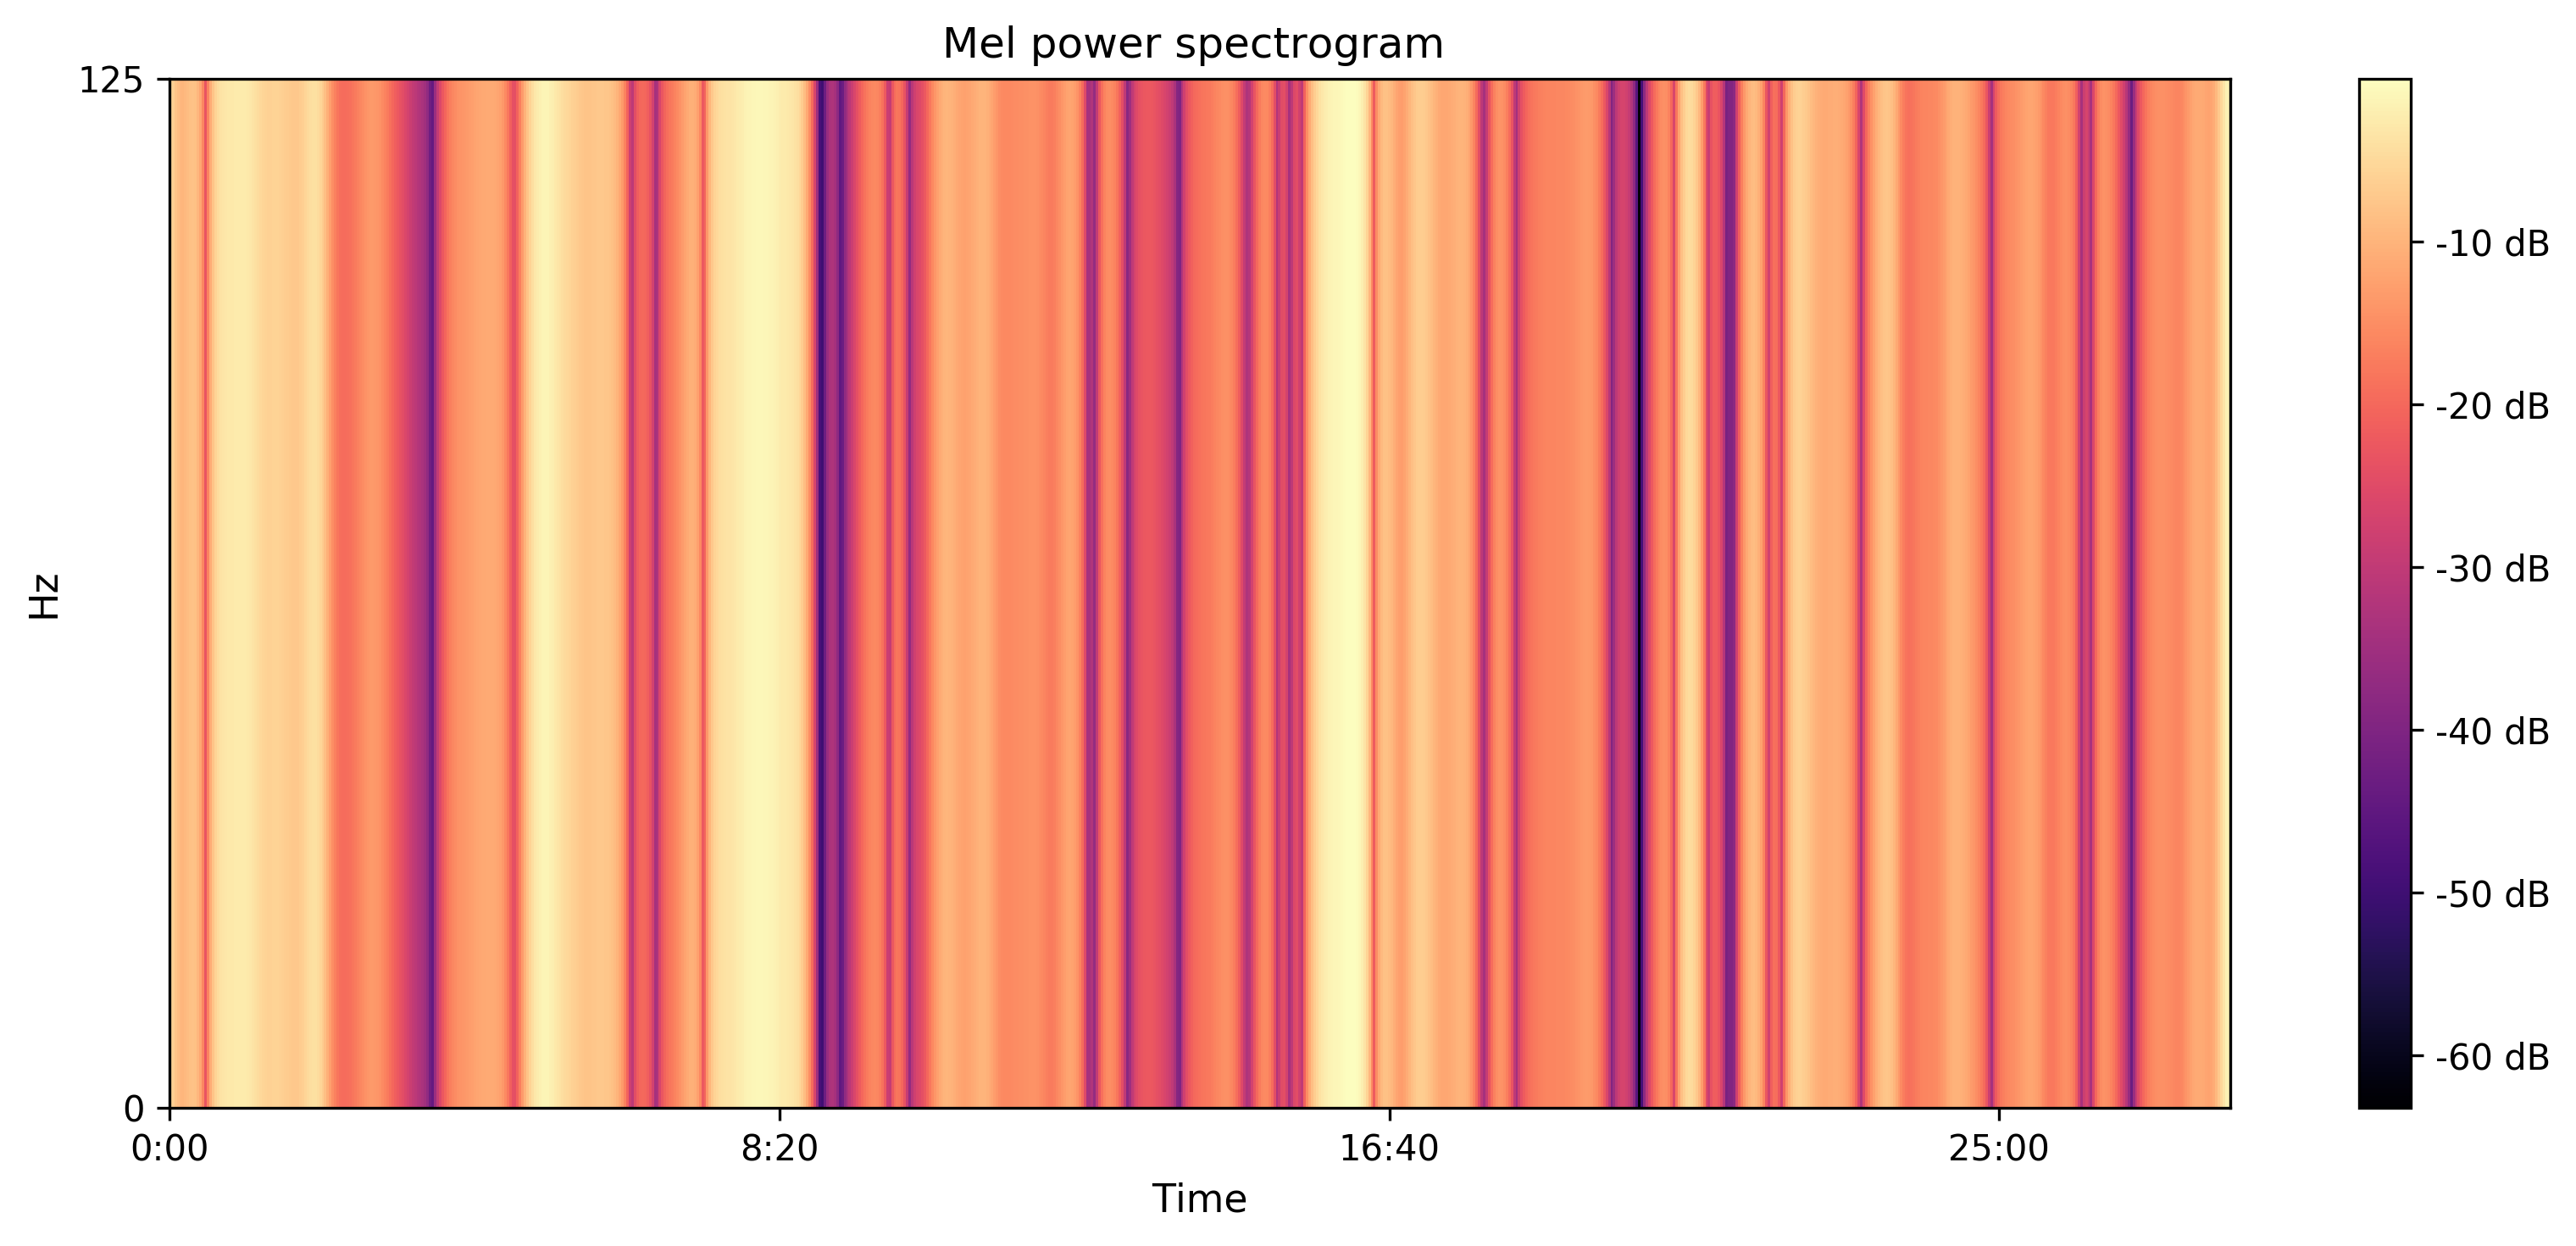

In [105]:
S = librosa.feature.melspectrogram(np.asfortranarray(all_data['data'][0][:,0]), sr=SAMPLING_RATE,n_mels=2,
                                n_fft = int(16*10**-3*SAMPLING_RATE),
                                hop_length=int(10*10**-3*SAMPLING_RATE)
                                )

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

# plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=SAMPLING_RATE, x_axis='time', y_axis='mel', fmax = 250/2)
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [83]:
S.shape

(2, 825)

In [85]:
S[0,:]

array([1.20478496e-02, 8.90767481e-03, 6.46192068e-03, 4.89875814e-03,
       4.13585780e-03, 4.01921710e-03, 4.38638683e-03, 5.03634941e-03,
       5.67598175e-03, 5.93635254e-03, 5.49743604e-03, 4.27454477e-03,
       2.55020405e-03, 9.43014922e-04, 1.90455365e-04, 8.36747291e-04,
       2.98895733e-03, 6.27198536e-03, 9.99963190e-03, 1.34595567e-02,
       1.61634944e-02, 1.79545414e-02, 1.89613644e-02, 1.94642134e-02,
       1.97540149e-02, 2.00379118e-02, 2.03980505e-02, 2.07922608e-02,
       2.10836399e-02, 2.10907348e-02, 2.06523277e-02, 1.96893662e-02,
       1.82432160e-02, 1.64724365e-02, 1.46071361e-02, 1.28814466e-02,
       1.14722447e-02, 1.04681309e-02, 9.87136085e-03, 9.61790606e-03,
       9.60041769e-03, 9.68838390e-03, 9.75007378e-03, 9.67888813e-03,
       9.41813085e-03, 8.97366554e-03, 8.40712711e-03, 7.81437941e-03,
       7.30153732e-03, 6.96901046e-03, 6.90634083e-03, 7.19267596e-03,
       7.89290573e-03, 9.03564505e-03, 1.05646346e-02, 1.22777754e-02,
      

# Melspectrogram

In [37]:
def feature_pipeline_mel(data):
    feature_data = []
    def getMelspectrogram(mdata):
        S = librosa.feature.melspectrogram(np.asfortranarray(mdata), sr=SAMPLING_RATE,n_mels=2,
                                n_fft = int(32*10**-3*SAMPLING_RATE),
                                hop_length=int(10*10**-3*SAMPLING_RATE)
                                )

        # Convert to log scale (dB). We'll use the peak power (max) as reference.
        log_S = librosa.power_to_db(S, ref=np.max)
        return log_S
    def process_signal(data):
        f_data = []
        for i in range(8):
            c_data = getMelspectrogram(data[:, i])
            f_data.append(c_data)

        return np.array(f_data)
    
    for d,i in zip(data,tqdm.tqdm(range(1,len(data)+1),desc="EXTRACTING DATA: ")):
        temp_data = process_signal(d)
        feature_data.extend([temp_data])
    return np.array(feature_data)

In [38]:
fileToImport = "mel_test_dict_feature_32_B.pickle"
if fileToImport in os.listdir(PICKLE_DIR):
    print("Fetching feature data from pickle file ...")
    all_data_feature = pickle.load(open(os.path.join(PICKLE_DIR, fileToImport),"rb"))
    print("Done!")
else:
    all_data_feature = all_data.copy()
    all_data_feature["data"] = feature_pipeline_mel(all_data["data"])
    reshape_feat = np.zeros((all_data_feature['data'].shape[0], all_data_feature['data'].shape[2],
                             all_data_feature['data'].shape[3], all_data_feature['data'].shape[1]))
    for i in range(all_data_feature['data'].shape[0]):
        for j in range(8):
            reshape_feat[i,:,:,j] = all_data_feature['data'][i,j,:,:]

    all_data_feature['data'] = reshape_feat
    del reshape_feat
    pickle.dump(all_data_feature,open(os.path.join(PICKLE_DIR, fileToImport),"wb"))

EXTRACTING DATA:  90%|█████████ | 9/10 [00:00<00:00, 13.45it/s]


In [39]:
all_data_feature['data'].shape

(10, 2, 825, 8)

In [ ]:
del all_data_feature

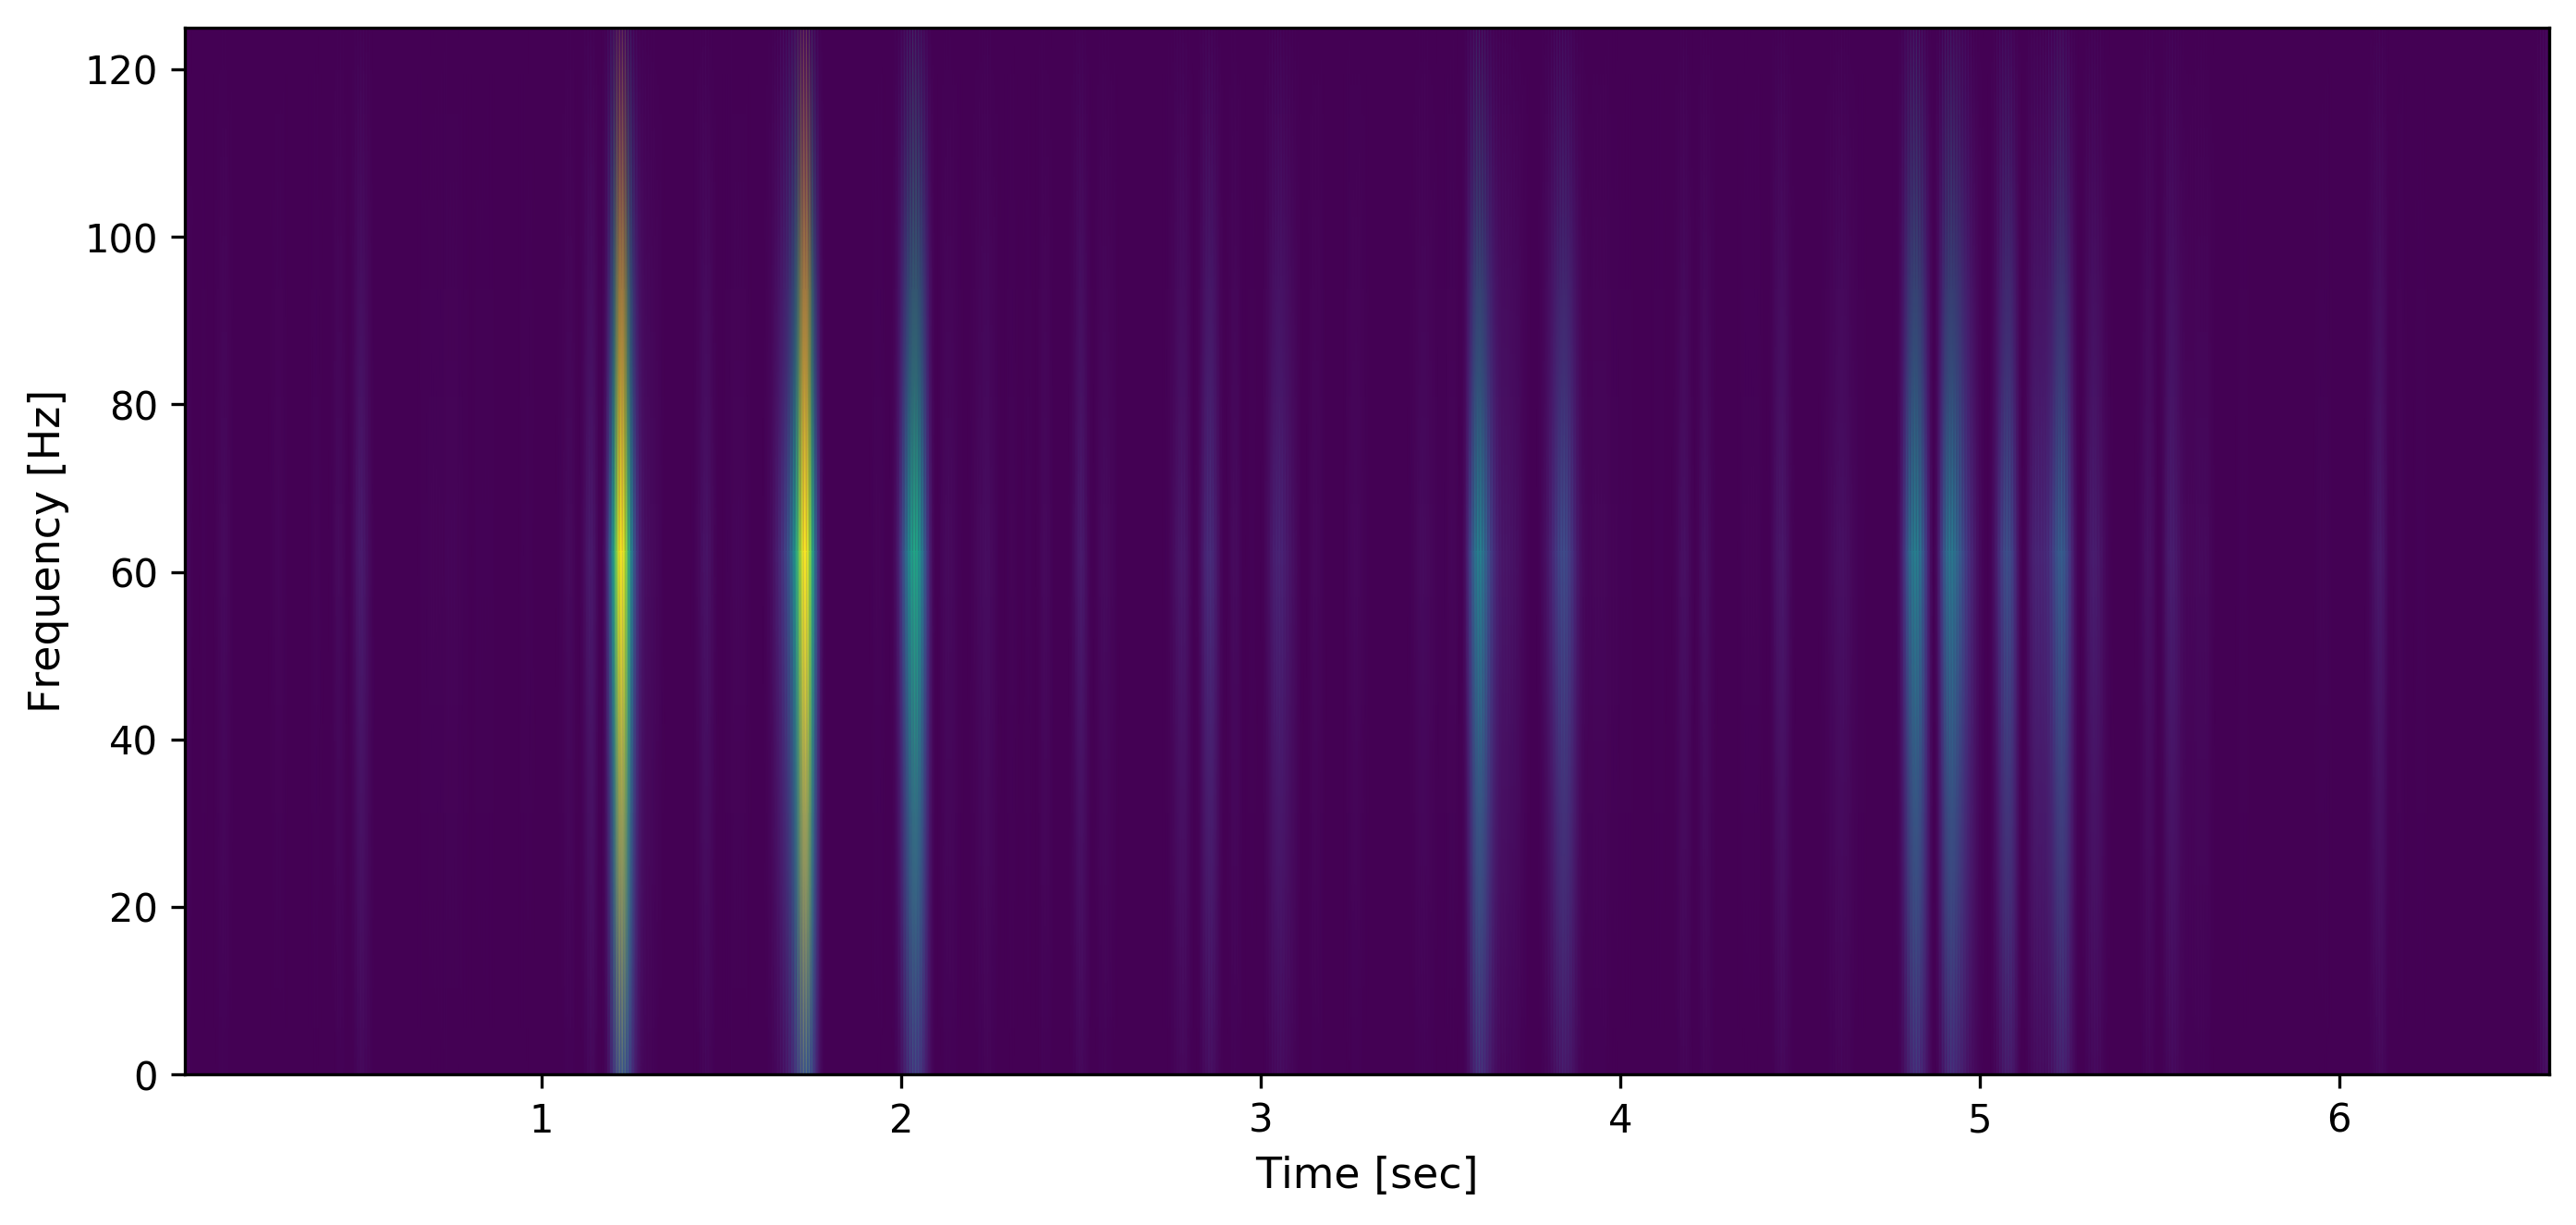

In [97]:
# win = sig.windows.hamming(50)
freq, time, spec =  sig.spectrogram(x=np.array(all_data['data'][0][:,3]), fs=SAMPLING_RATE,
                    nperseg = int(16*10**-3*SAMPLING_RATE),
                    noverlap =int(10*10**-3*SAMPLING_RATE)                                   
                                   )
plt.pcolormesh(time, freq, spec, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [94]:
spec.shape

(3, 823)